In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pathlib

In [2]:
dataset_url = "WasteImagesDataset"
data_dir = pathlib.Path(dataset_url)

In [3]:
print(data_dir)

WasteImagesDataset


WasteImagesDataset\Aluminium\alum (115).jpg


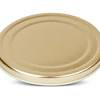

In [4]:
electronic = list(data_dir.glob('Aluminium/*'))
print(electronic[18])
PIL.Image.open(str(electronic[18]))

In [5]:
img_height, img_width = 224, 224
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 5078 files belonging to 9 classes.
Using 4063 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 5078 files belonging to 9 classes.
Using 1015 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']


In [8]:
resnet_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top = False,
    input_shape = (224, 224, 3),
    pooling = 'avg',
    classes = 9,
    weights = 'imagenet'
)

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation = 'relu'))
resnet_model.add(Dense(9, activation = 'softmax'))

In [9]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 9)                 4617      
                                                                 
Total params: 24,641,417
Trainable params: 1,053,705
Non-trainable params: 23,587,712
_________________________________________________________________


In [10]:
resnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
epochs = 10
history = resnet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/10
127/127 [==============================] - 45s 263ms/step - loss: 0.6995 - accuracy: 0.7684 - val_loss: 0.4414 - val_accuracy: 0.8562
Epoch 2/10
127/127 [==============================] - 30s 233ms/step - loss: 0.2301 - accuracy: 0.9168 - val_loss: 0.3847 - val_accuracy: 0.8867
Epoch 3/10
127/127 [==============================] - 30s 232ms/step - loss: 0.1306 - accuracy: 0.9532 - val_loss: 0.4148 - val_accuracy: 0.8749
Epoch 4/10
127/127 [==============================] - 30s 232ms/step - loss: 0.0630 - accuracy: 0.9815 - val_loss: 0.3893 - val_accuracy: 0.8887
Epoch 5/10
127/127 [==============================] - 30s 232ms/step - loss: 0.0433 - accuracy: 0.9874 - val_loss: 0.3902 - val_accuracy: 0.8906
Epoch 6/10
127/127 [==============================] - 30s 233ms/step - loss: 0.0146 - accuracy: 0.9990 - val_loss: 0.4120 - val_accuracy: 0.8966
Epoch 7/10
127/127 [==============================] - 30s 233ms/step - loss: 0.0096 - accuracy: 0.9995 - val_loss: 0.4210 - val_ac

In [12]:
import h5py

resnet_model.save('Resnet50SavedModel.h5')

with h5py.File('Resnet50SavedModel.h5', 'a') as hf:
    for key in history.history.keys():
        hf.create_dataset(key, data=history.history[key])

In [15]:
print(os.getcwd())

C:\Users\offic


1/1 [==============================] - 0s 30ms/step


<Figure size 1000x1000 with 0 Axes>

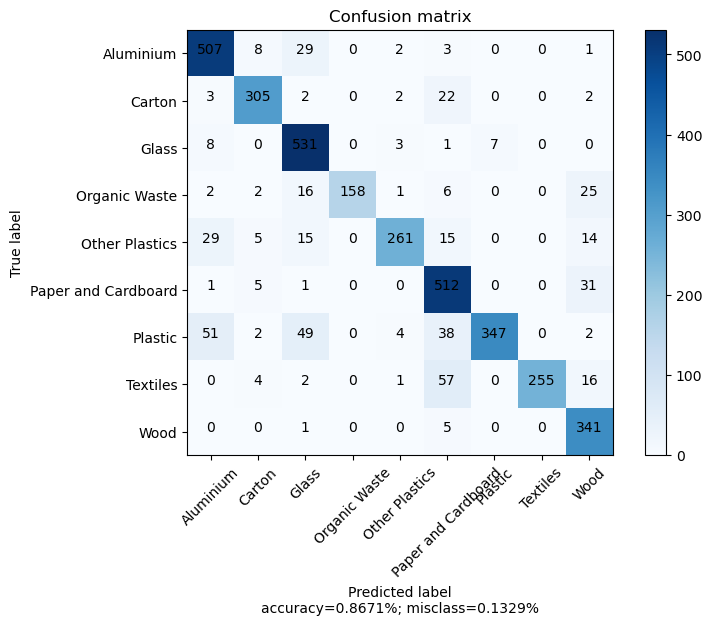

In [16]:
def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

path = "WasteImagesDataset/"
for i in os.listdir(path):
  folderPath = os.path.join(path, i)
  for j in os.listdir(folderPath)[:550]:
    fullPath = os.path.join(folderPath, j)
    try:
      img = tf.keras.preprocessing.image.load_img(fullPath, target_size=(224, 224))
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0) 

      preds = resnet_model.predict(img_array)
      true.append(class_names.index(i))
      predictions.append(np.argmax(preds))
    except:
      print("Error on image:", fullPath)

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), class_names )